## Keras with Final/Best Hyperparamter Classification
This notebooks creates the Forward Feed Neural Network for classifying the Fashion MNIST data with the what we determined as the best hyperparameters that were tested/varied (learning rate, number of nodes, etc...) elsewhere. 
### All python Imports

In [1]:
# Normal Sci. Comp. Imports
import numpy as np
import matplotlib.pyplot as plt
# create random number generator for later/throughout
rng = np.random.default_rng(seed=120695)
# Load the keras data set module:
from tensorflow.keras.datasets import fashion_mnist
# import keras stuff
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

## Data importing and then Normalization, etc

In [2]:
# with fashion mnist model data is already partitioned into training and validation
(X, Y), (x_test, y_test) = fashion_mnist.load_data()
x_train, x_valid = X[:48000], X[48000:]
y_train, y_valid = Y[:48000], Y[48000:]
# Reshape and Normalize the data
x_train = x_train.reshape(-1, 784)
x_valid = x_valid.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)
norm_tr = x_train / 255
norm_va = x_valid / 255
norm_tst = x_test / 255
# Categorically encode the data (one-hot encoding)
num_categories = len(np.unique(y_train))
y_tr_encoded = keras.utils.to_categorical(y_train, num_categories)
y_va_encoded = keras.utils.to_categorical(y_valid, num_categories)
y_tst_encoded = keras.utils.to_categorical(y_test, num_categories)

## Create the Model 
The FFNN model is created to have 3 hidden layers with 512 nodes per layer and a optimization learning rate of $0.0007$.

In [3]:
model = Sequential() 
# input layer and first hidden layer
model.add(Dense(units=512, activation='relu', input_shape=(784,)))
# second hidden layer
model.add(Dense(units=512, activation='relu',))
# third hidden layer
model.add(Dense(units=512, activation='relu',))
# output layer
model.add(Dense(units=10, activation='softmax'))
opt = keras.optimizers.Adam(learning_rate=0.0007)
# now compile the models with the the correct loss, metrcs and optimzation method
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=opt)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 932,362
Trainable params: 932,362
Non-trainable params: 0
_________________________________________________________________


## Train the models

In [4]:
history = model.fit(
    x=norm_tr, y=y_tr_encoded, batch_size=512, epochs=22, verbose=1, validation_data=(norm_va, y_va_encoded)
)

Epoch 1/22
94/94 [==============================] - 2s 8ms/step - loss: 0.6204 - accuracy: 0.7863 - val_loss: 0.4507 - val_accuracy: 0.8418
Epoch 2/22
94/94 [==============================] - 1s 6ms/step - loss: 0.3910 - accuracy: 0.8610 - val_loss: 0.3731 - val_accuracy: 0.8643
Epoch 3/22
94/94 [==============================] - 1s 6ms/step - loss: 0.3463 - accuracy: 0.8758 - val_loss: 0.3645 - val_accuracy: 0.8659
Epoch 4/22
94/94 [==============================] - 1s 6ms/step - loss: 0.3176 - accuracy: 0.8840 - val_loss: 0.3282 - val_accuracy: 0.8797
Epoch 5/22
94/94 [==============================] - 1s 6ms/step - loss: 0.2862 - accuracy: 0.8937 - val_loss: 0.3194 - val_accuracy: 0.8827
Epoch 6/22
94/94 [==============================] - 1s 6ms/step - loss: 0.2695 - accuracy: 0.9002 - val_loss: 0.3234 - val_accuracy: 0.8809
Epoch 7/22
94/94 [==============================] - 1s 6ms/step - loss: 0.2548 - accuracy: 0.9054 - val_loss: 0.3170 - val_accuracy: 0.8887
Epoch 8/22
94/94 [==

## Save training and validation accuracy data to a file

In [6]:
out_data = np.empty(shape=(2, 22))
out_data[0] = history.history['accuracy']
out_data[1] = history.history['val_accuracy']
out_data = out_data.T
np.savetxt(fname='TF_datasets/FFNN_Best_Acc_data.txt', X=out_data, header='Tr Acc ----- Val Acc.')

### Function to determine some misclassification stats if we would like them

In [7]:
def mis_cls_stats(prds:np.array, truth:np.array):
    """ Identify some statistics about the misclassifications like what was mis classifided 
        how many times it was misclassifed, what was most often classified for incorrectly
        for it, etc.
        prds = predictions
        truth = true labels
    """
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    # get number of sample/test
    M = truth.shape[0]
    # number of correct and wrong predictions
    num_r, num_w = np.sum(prds==truth), np.count_nonzero(prds-truth)
    print(f"The model gave {num_r} correct and {num_w} wrong predictions giving")
    print(f"an accuracy rate of {(num_r)/M} and an error rate of {(num_w)/M} \n")
    # first get the indices of the predictions matrix that were incorrect
    idx = np.nonzero(prds!=truth)[0]
    # now get all the labels that were miss classified and how many times so (counts_wrong)
    lbls, counts_w = np.unique(prds[idx], return_counts=True)
    # also get the correct number of labels and simplify the classes list
    counts_c = np.empty_like(counts_w)
    usd_cls = []
    for i in range(len(counts_w)):
        counts_c[i] = np.sum(truth == lbls[i])
        usd_cls.append(class_names[lbls[i]])
    # determine the individual class accuracies 
    cls_acc = 100*(1 - counts_w/counts_c)
    for i, l in enumerate(lbls):
        print(f"Label/class {class_names[l]} was miss labeled/classified {counts_w[i]} times")
        print(f"So approximately {100 *counts_w[i]/num_w:.2f}% of the misslabels were for {class_names[l]}")
        print(f"the accuracy rate for the {class_names[l]} alone was {cls_acc[i]:.2f}%\n")
        
    # plot horizonal bar char displaying misclassification per class
    fig1, ax1 = plt.subplots(figsize=(9,6))
    y_pos = np.arange(len(lbls))
    ax1.barh(y_pos, counts_w, align='center')
    ax1.set_yticks(y_pos, labels=usd_cls)
    ax1.set_xlabel('Miss Classifications')
    ax1.set_title(f'Num. Misclassifications For Model - Total = {num_w}')
    # Now create a verical bar chart for each class showing what was the miss classifications 
    # maximum of 20 sub figures and minimum of 2 (realistically going to have some misclassif.)
    num_cols = 2
    num_images = 2*len(lbls)
    num_rows = int(np.ceil(num_images/4))
    # plots is an example image of a label/class then its misclassification charts of what was 
    # predicted instead of it and some other things. Us two images per class and we want for 
    # images per row. 
    fig, ax = plt.subplots(num_rows, 2*num_cols, figsize=(2.5*2*num_cols, 2*num_rows))
    # tmp_img = np.empty((28,28), dtype=float)
    for i, l in enumerate(lbls):
        i_r, i_c = int(i/2), 0
        if i%2==1:
            i_c = 2
        # first display an image of the label
        jdx = np.nonzero(truth == l)[0][0]
        ax[i_r][i_c].set_xticks([])
        ax[i_r][i_c].set_yticks([])
        ax[i_r][i_c].imshow(x_test[jdx].reshape(28,28), cmap='gray')
        ax[i_r][i_c].set_xlabel(f"{class_names[l]}, {cls_acc[i]:.2f}% Acc.", fontsize=9)
        # now display bar chart of what was predicted instead
        ids = np.nonzero(prds[idx]==l)
        gues, g_counts = np.unique(truth[idx[ids]], return_counts=True)
        ax[i_r][i_c+1].bar(range(len(gues)), g_counts, align='center', color='red')
        ax[i_r][i_c+1].set_ylabel('Amount', fontsize=9)
        ax[i_r][i_c+1].set_xlabel('Wrong Predictions', fontsize=9)
        g_lbl = []
        for i in range(len(gues)):
            g_lbl.append(class_names[gues[i]])
        ax[i_r][i_c+1].set_xticks(range(len(gues)), g_lbl, fontsize=6.5, rotation=65)
        ax[i_r][i_c+1].set_title(f"{class_names[l]}, Misclassifications", fontsize=9)
        
    plt.tight_layout()
    plt.show()

### Make the predictions now and then determine the missclassification and other stats

The model gave 8919 correct and 1081 wrong predictions giving
an accuracy rate of 0.8919 and an error rate of 0.1081 

Label/class T-shirt/top was miss labeled/classified 111 times
So approximately 10.27% of the misslabels were for T-shirt/top
the accuracy rate for the T-shirt/top alone was 88.90%

Label/class Trouser was miss labeled/classified 4 times
So approximately 0.37% of the misslabels were for Trouser
the accuracy rate for the Trouser alone was 99.60%

Label/class Pullover was miss labeled/classified 152 times
So approximately 14.06% of the misslabels were for Pullover
the accuracy rate for the Pullover alone was 84.80%

Label/class Dress was miss labeled/classified 107 times
So approximately 9.90% of the misslabels were for Dress
the accuracy rate for the Dress alone was 89.30%

Label/class Coat was miss labeled/classified 270 times
So approximately 24.98% of the misslabels were for Coat
the accuracy rate for the Coat alone was 73.00%

Label/class Sandal was miss labeled/clas

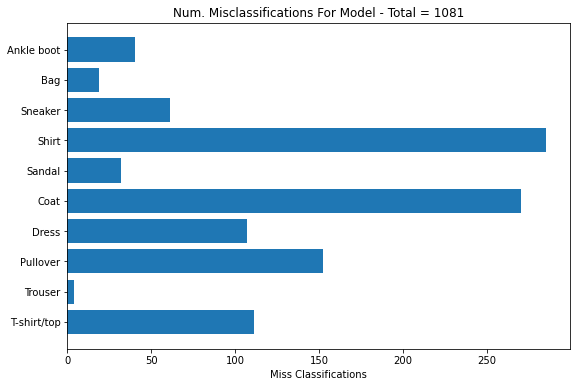

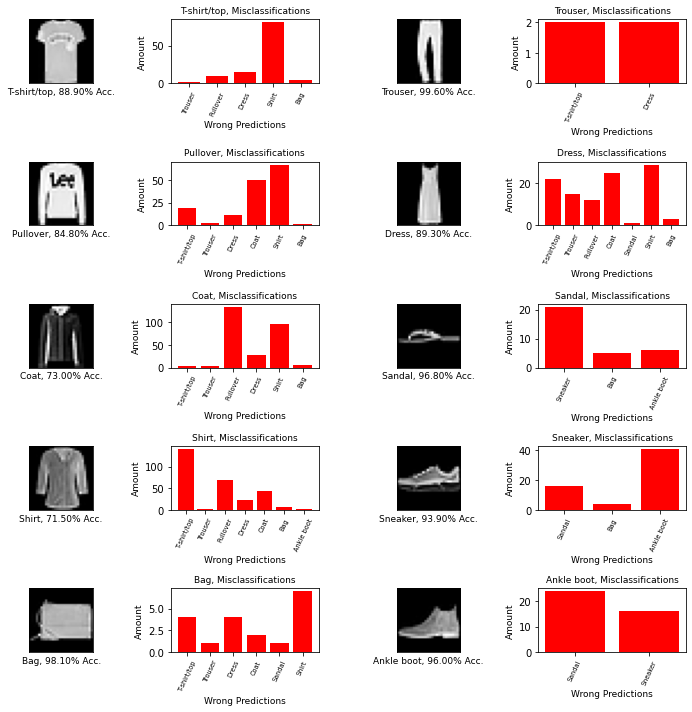

In [8]:
preds2 = np.argmax(model.predict(x=norm_tst), axis=1)
mis_cls_stats(preds2, y_test)

## Extra:
A separate notebook takes the data saved above to create a plot of the training and validation accuracy from one epoch to the next but if you want to display it here and save it to the current working directory copy and past the following lines of python code into a code cell and run it. 
```Python
fig = plt.figure()
plt.plot(np.arange(1,23), out_data[:, 0]*100, 'k.-', np.arange(1,23), out_data[:, 1]*100, 'b.-', markersize=16)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('% Accuracy', fontsize=16)
plt.legend(['Train', 'Validation'], fontsize=16)
plt.show()
plt.savefig(fname='30epochs.png', format='png')
```

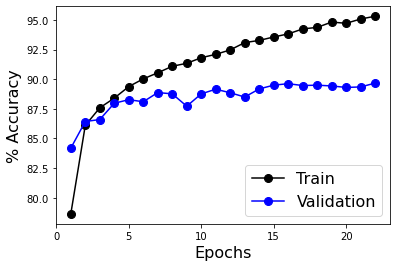

In [10]:
fig = plt.figure()
plt.plot(np.arange(1,23), out_data[:, 0]*100, 'k.-', np.arange(1,23), out_data[:, 1]*100, 'b.-', markersize=16)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('% Accuracy', fontsize=16)
plt.legend(['Train', 'Validation'], fontsize=16)
plt.show()